In [1]:
#Modules
import numpy as np
import numpy.random as r
import itertools as it
import pandas as pd
import time
import matplotlib.pyplot as plt
import math
import copy
import io
from pulp import *

In [2]:
#data
acyclique = pd.read_csv("Data/acyclique.csv",sep=";")
comparaison=pd.read_csv("Data/Comparaison.csv",sep=";")
ordre = pd.read_csv("Data/ordre.csv",sep=";")
arc=pd.read_csv("Data/Arc.csv",sep=";")
noeud=pd.read_csv("Data/Noeuds.csv",sep=";")
ressource=pd.read_csv("Data/Ressource.csv",sep=";")
contrainte=pd.read_csv("Data/Contraintes.csv",sep=";")
nd_res=pd.read_csv("Data/Noeud_Ressource.csv",sep=";")
pretrmt=pd.read_csv("Data/pretraitement.csv",sep=";")
comparaison2=pd.read_csv("Data/Comparaison2.csv",sep=";")

<h1><center><b>Compte-Rendu de l'étude de la résolution des problèmes de PCCC (Plus Court Chemin Contraint)</b></center></h1>


## Formalisation du problème

Soit G = (V, A) un graphe orienté avec : 

*   |V | = n
*   |A| = m
	
Soit R un ensemble de ressources avec |R| = $n_r$.
A chaque arc (i,j) de A, on associe un cout c<sub>i,j</sub>  et un vecteur de consommation de ressource t<sub>i,j</sub>  (on suppose positif ) de dimension $n_r$ . Par ailleurs, on suppose que G ne contient pas de cycle de poids strictement négatif.
On considère des contraintes de ressources finales et à fenêtre de temps portant uniquement sur la borne supérieure.

**Objectif:**
On cherche à trouver un chemin qui minimise le coût et dont la consommation de ressource (noté T) respecte les contraintes.








## Modélisation et génération du graphe



### <u>Modelisation</u>
Nous avons décidé de modéliser nos graphes à l'aide du paradigme de la Programmation Orienté Objet(POO). 

Vous pouvez voir ci-dessous la classe *Graphe* dont chaque instance contient les attributs **ressource** (liste contenant l'ensemble des ressources),**nb_ressource**,  **noeud**, **nb_arc**  et **arc** (dictionnaire contenant l'ensemble des arcs avec leurs coût et leur consommation de ressource).

Les principales méthodes de la classe *Graphe*  permettent notamment de pouvoir ajouter des arcs, noeuds, ressources. Par ailleurs, nous avons avons aussi ajouté une méthode **isAcyclic** qui permet de savoir si un graphe est acyclique par un parcour en profondeur. Si le graphe est acyclique, un ordre topologique de ses sommets est stoké dans l'attribut **sigma**.


In [3]:
"""
    Modélisation d'un graphe : classe Graphe
    Les arcs du graphes seront modélisé sous la forme d'un double-dictionnaire 
    arc[S1 : sommet origine][S2 : sommet but ] = vecteur 
    Si le vecteur existe, alors il y a un arc entre S1 et S2
    Le vecteur sera de taille 1+R et représentera le vecteur cout et ressources de l'arc
    vecteur[0] = cout de l'arc
    vecteur[i] = Consommation ressource i sur l'arc ou i = [| 1 ; R |]
    
"""
class Graphe:
    nb_graph=0

    #res = nom des ressources à considérer
    def __init__(self,res=None):
        self.arc={} #double dictionnaire
        self.nb_arc=0
        self.noeud=[] #noeud
        if(type(res) is not list):
          res=[res]
        self.ressource=res # nom des ressources
        #Nombre de ressource
        if(res==[None]):
          self.nb_ressources = 0
        else:  
          self.nb_ressources = len(res) 
        Graphe.nb_graph+=1
        #Cas ou on veut verifer son caractère acyclique
        self.sigma = {} #ordre topologique
        self.couleur ={} #detection de circuit
    
    #Fonction permettant d'ajouter une/des ressources
    def ajout_ressource(self,nom_ress):
      if (type(nom_ress) is not list):
        nom_ress=[nom_ress]
      for nom in nom_ress:
        if(self.ressource==[None]):
          self.ressource=[nom]
        else: 
          self.ressource.append(nom)
        self.nb_ressources+=1
        for source in self.arc.keys():
          for cible in self.arc[source].keys():
           self.arc[source][cible]=np.append(self.arc[source][cible],0)
        
    #Fonction permettant l'ajout d'un/des sommet au graphe
    def ajoutNoeud(self,sommet):
      if (type(sommet) is not list):
        sommet=[sommet]
      sommet=[str(som) for som in sommet]
      for som in sommet:
        if (som in self.noeud):
          print('Le sommet ',som,' est déjà présent dans votre graph')
        else:
          self.noeud.append(som)
          self.couleur[som]=0
    
    #Fonction permettant l'ajout d'un/des arc entre 2 sommets
    def ajoutArc(self,origin,dest,conso):
        #conso = Cout de l'emprunt de l'arc et consommation des ressources
        if(type(origin) is not list):
          origin=[origin]
        origin=[str(ori) for ori in origin]
        if(type(dest) is not list):
          dest=[dest]
        dest=[str(des) for des in dest]
        if (type(conso) is not list):
          conso=[conso]
        if(type(conso[0]) is not list):
          conso=[conso]
        for i in range(len(origin)):
          if(len(conso[i])==self.nb_ressources+1):
            if(origin[i] not in self.noeud):
                self.ajoutNoeud(origin[i])
            if(origin[i] not in self.arc.keys()):
                self.arc[origin[i]]={}
            if (dest[i] not in self.noeud):
              self.ajoutNoeud(dest[i])
            if (dest[i] not in self.arc[origin[i]].keys()):
                self.arc[origin[i]][dest[i]]=np.array([conso[i]])
                self.nb_arc+=1
            else:
                present=any([all(conso[i]==self.arc[origin[i]][dest[i]][h]) for h in range(len(self.arc[origin[i]][dest[i]]))])
                if (not present):
                    self.arc[origin[i]][dest[i]]=np.append(self.arc[origin[i]][dest[i]],np.array([conso[i]]),axis=0)
                    self.nb_arc+=1
                else:
                    #print(" l'arc (",origin[i],";",dest[i],") est déjà présent dans ce graphe avec le meme vecteur conso")
                    pass
          else:
            print("Le vecteur conso de l'arc (",origin[i],dest[i],") n'a pas la bonne dimention. L'arc n'a donc pas été ajouté") 
        
    #Fonction retournant les predecesseurs d'un sommet sous forme de liste    
    def predecesseurs(self,sommet):
        sommet=str(sommet)
        liste_pred = []
        for key in self.arc.keys():
            if(sommet in self.arc[key].keys()):
                liste_pred.append(key)  
        return(liste_pred)
        
    #Fonction retournant les successeurs d'un sommet sous forme de liste
    def successeurs(self,sommet):
        sommet=str(sommet)
        liste_suc = []
        if(sommet in self.arc.keys()):
            for key in self.arc[sommet].keys():
                liste_suc.append(key)
        return(liste_suc)
    
    #Fonction affichant le graphe sous forme
    # Sommet(nombre de successeurs) : [{successeur_i : vecteur conso }, ... ]
    def affiche(self):
        for key in self.arc.keys():
            print(str(key)+"("+str(len(self.arc[key]))+"): [ ",end="")
            for cle in self.arc[key].keys():
                print("{"+str(cle)+" : "+str(self.arc[key][cle])+" } ,",end="")
            print("]")

    def colorier_noir(self,s,k):
        if(self.couleur[s]!=1):
            self.couleur[s]=1
            self.sigma[s] = k
        k+=-1
        for t in self.predecesseurs(s):
            if self.couleur[t]==2:
                if( all(self.couleur[i] == 1 for i in self.successeurs(t) )):
                    self.colorier_noir(t,k)
    
    def isAcyclic(self):
        acyclique = True
        k=len(self.noeud)
        PILE = []
        while(any(self.couleur[i] == 0 for i in self.noeud)):
            for i in self.noeud:
                if(self.couleur[i]==0):PILE=[i];break;
            while(len(PILE)!=0):
                traite = PILE[0]
                PILE.remove(traite)
                if(self.couleur[traite]==0):self.couleur[traite]=2;
                if(any(self.couleur[i]==2 for i in self.successeurs(traite))):
                    acyclique = False
                    for i in self.noeud:
                        self.couleur[i]=0
                    self.sigma ={}
                    return(acyclique)
                for i in self.successeurs(traite):
                    if(self.couleur[i]==0):PILE.insert(0,i);
                if(all(self.couleur[i]==1 for i in self.successeurs(traite)) or len(self.successeurs(traite))==0):
                    self.colorier_noir(traite, k)
                    k = min(self.sigma[k] for k in self.sigma.keys())-1
        for i in self.noeud:
            self.couleur[i]=0
        return(acyclique)

In [4]:
#Exemple d'utilisation
#--------------------------------------------------------------------------#
Paul = Graphe()
Paul.ajout_ressource(["nb_colab","distance","energie"])
Paul.ajoutNoeud(["Debut","Meetings","Conferences","Financement","Corruption","Demagogie","Election","Decheance"])
Paul.ajoutArc(["Debut","Debut","Debut","Financement","Conferences","Conferences","Meetings","Corruption","Corruption","Demagogie","Election"],
              ["Meetings","Conferences","Financement","Conferences","Corruption","Demagogie","Corruption","Election","Decheance","Election","Decheance"],
              [[15,1,3,4],[10,1,4,5],[8,2,6,5],[4,5,6,2],[20,2,0,1],[2,3,9,1],[10,3,0,4],[1,6,2,8],[2,6,6,4],[4,3,2,2],[4,5,6,4],[5,6,7,8]])
Paul.affiche()
print("\n Paul est acyclique :",Paul.isAcyclic())
print("\n Un ordre topologique des sommets de Paul \n",Paul.sigma)


Debut(3): [ {Meetings : [[15  1  3  4]] } ,{Conferences : [[10  1  4  5]] } ,{Financement : [[8 2 6 5]] } ,]
Financement(1): [ {Conferences : [[4 5 6 2]] } ,]
Conferences(2): [ {Corruption : [[20  2  0  1]] } ,{Demagogie : [[2 3 9 1]] } ,]
Meetings(1): [ {Corruption : [[10  3  0  4]] } ,]
Corruption(2): [ {Election : [[1 6 2 8]] } ,{Decheance : [[2 6 6 4]] } ,]
Demagogie(1): [ {Election : [[4 3 2 2]] } ,]
Election(1): [ {Decheance : [[4 5 6 4]] } ,]

 Paul est acyclique : True

 Un ordre topologique des sommets de Paul 
 {'Decheance': 8, 'Election': 7, 'Demagogie': 6, 'Corruption': 5, 'Conferences': 4, 'Financement': 3, 'Meetings': 2, 'Debut': 1}


## <u>Générateurs de graphe</u>

Afin de rentrer dans le cadre d'un problème de PCCC, les graphes que nous générons doivent remplir certains critères. 

  * Tout d'abord, la source n'a aucun prédécésseur et le puit n'a aucun succésseur. 
  * De plus, chaque sommet doit avoir au moins un successeur et un prédécésseur afin de pouvoir potentiellement faire partie de la solution.
  * Il doit exister un chemin entre la source le puit

### Generation aleatoire de graphe

Le principe est inspiré de la fonction *fast_gnp_random_graph* de la librairie *Networkx*. Elle prend comme paramètre le nombre de sommets et une probabilité p strictement comprise entre 0 et 1. 

On commence par générer un chemin de façon aléatoire entre la source et le puit, sans prendre en compte la proba entrée en paramètre. Dans le pire cas, la procédure crée un très grand nombre d'arcs ce qui nullifie l'influence de la probabilité passée en paramètre.

Une fois que l'existence d'au moins un chemin assurée, on parcourt tous les n sommets et on crée un arc entre 2 sommets donnés en récupérant une réalisation d'une loi uniforme entre 0 et 1. Si la réalisation est inférieure ou égale à la proba, l'arc est créé. Dans le cas contraire on passe au sommet suivant. 

On n'a pas de contrôle sur beaucoup de paramètres du graphe (le nombre de ressources...) mais c'est une fonction intéressante pour générer rapidement un graphe aléatoire.


In [5]:

def graphe_alea(nb_sommets,proba=0.5): #proba = probabilité de generer un arc
    graphe=Graphe(res=["R1","R2"])
    graphe.ajoutNoeud([i for i in range(nb_sommets+1)])
    source=0;puit=nb_sommets
    if(proba<=0 or proba>=1):
        print("La proba doit être strictement comprise entre 0 et 1")
    else:
        #Creation chemin entre source et puit
        s1=source
        s2=r.randint(source+1,nb_sommets)
        conso = [r.randint(0,10),r.randint(0,20),r.randint(0,20)]
        graphe.ajoutArc(s1,s2,conso)
        while(s2!=puit):
          s1=s2
          s2=r.randint(source+1,nb_sommets)
          if(s1!=s2): #On evite les boucles sur les sommets
            conso = [r.randint(0,10),r.randint(0,20),r.randint(0,20)]
            graphe.ajoutArc(s1,s2,conso)
          else:
            s2+=1
            conso = [r.randint(0,10),r.randint(0,20),r.randint(0,20)]
            graphe.ajoutArc(s1,s2,conso)
          if(s2==puit):
            conso = [r.randint(0,10),r.randint(0,20),r.randint(0,20)]
            graphe.ajoutArc(s1,s2,conso)
        #Generation d'arcs aleatoires entre les différents sommets
        """Inspire de fast_gnp_random_graph de Networkx"""
        lp = math.log(1-proba)
        s1=source
        while(s1!=puit):
          s2 = r.randint(s1,puit)
          if(s1==s2):
            s2+=1
          lr=math.log(1-r.random())
          if(lr>=lp):
            if(s1!=s2):
              conso = [r.randint(0,10),r.randint(0,20),r.randint(0,20)]
              graphe.ajoutArc(s1,s2,conso)
          else:
            s1+=1
    return(graphe)


In [6]:
#Exemple d'utilisation
G1=graphe_alea(5)
G1.affiche()

0(2): [ {4 : [[ 8  1 10]] } ,{1 : [[ 2 15 18]] } ,]
4(1): [ {5 : [[ 2 17  7]
 [ 3 10 19]] } ,]
1(1): [ {2 : [[ 4 14  8]] } ,]


### Generateur de graphe par niveau

La fonction *generateur_graph* ci dessous permet de générer des graphes remplissant les critères ci dessus et prends en paramètre:
  * **n** le nombre de sommets en dehors de la source et du puit
  * **m** : le nombre d'arcs du graph
  * **nb_ress**: le nombre de ressources
  * **a** : borne inf lors du tirage aleatoir des coûts et ressources des arcs
  * **b=10** : borne sup lors du tirage aleatoir des coûts et ressources des arcs
  * **graph_simple**: Booléan permettant de construire des graphes simples
  * **graph_acyc**: Booléan permettant de construire des graphes acyclique
  

Cette fonction permet de générer des graphes en plusieurs étapes.
##### **Première étape : Division**
Elle crée un graph avec **n**+2 sommets numerotés de 0 à **n**+1 avec **nb_ress** ressources. Puis elle va répartir ces sommet en niveaux afin de garantir la creation d'un chemin entre la source et le puit. Le premier niveau comporte un seul sommet : la source; le dernier niveau comporte un seul sommet: le puit. Le nombre de niveau entre la source et le sommet est tiré aleatoirement ainsi que le nombre de sommet par niveau avec bien sur la contrainte que la somme des sommets vaut **n** (hors puit et source).
##### **Deuxième étape : Liaison Niveau**
La fonction choisi deux sommets par niveau ( hormis le premier et dernier niveau qui ne comporte que la source et le puit) qui seriviront à faire la **liaison inter-niveau**: un pour la liaison entre son niveau et le précédent, un pour la liaison entre son niveau et le suivant.  Puis si, le sommet qui fait la liaison entre son niveau et le suivant n'est pas le même que celui qui fait la liaison  entre son niveau et le précédent, la fonction choisi un autre sommet de ce niveau afin de faire la **liaion intra-niveau**. Ainsi à l'issu de cette étape il existe un chemin entre la source et le puit. Puis, on lie les sommets n'ayant pas servies aux liaisons entre eux de manière à ce que chacun ait un successeur et un prédécesseur. 

##### **Troisième étape : Completer le nombre d'arc**
La dernière étape consiste à ajouter des arcs entre sommet aléatoire afin que notre graph ait m arcs.

Par ailleur elle permet aussi de générer des graphes acycliques. En effet, pour cela il suffit simplement de verifier qu'avant d'ajouter un arc (i,j), i<j.


In [7]:

def division(n,m):
    #Nombre de niveau
    nb_niv=r.randint(1,n) if m!=(n+1) else n
    #Nombre de noeud par niveau
    nb_nd=[0]
    for i in range(nb_niv):
        max=n-np.sum(nb_nd)-(nb_niv-i-1)
        nb_nd.append(r.randint(1,max))
    #Contrainte sur le degré de liberte du nombre de noeud par niveau
    ind_cont=r.randint(1,nb_niv+1)
    nb_nd[ind_cont]=n-np.sum([j for i, j in enumerate(nb_nd) if i!=ind_cont])
    #construction des noeud
    nb_nd=np.cumsum(nb_nd)
    resu={j+1:[i+1 for i in range(nb_nd[j],nb_nd[j+1])] for j in range(len(nb_nd)-1)}
    resu[0]=["s"]
    resu[nb_niv+1]=["t"]
    return(resu)


def generateur_graph(n,m,nb_ress=1,a=1,b=10,graph_simple=True,graph_acyc=False):
    if m<(n+1):
        print("Vous devez au moins entrez ",n+1, " arcs")
        return(-1)
    #Initialisation du graph    
    g=Graphe([i for i in range(1,nb_ress+1)])
    g.ajoutNoeud(['s','t'])
    g.ajoutNoeud([i for i in range(1,n+1)])
    
    #Creation des niveau    
    Niveau=division(n,m)
    nb_niv=len(Niveau)
    
    #Liaison niveau
    #print("Niveau",Niveau)
    P_ind=[r.choice(Niveau[x]) for x in range(1,nb_niv)] if not graph_acyc else [np.min(Niveau[x]) for x in range(1,nb_niv-1)]+['t']
    P_noeud=[r.choice(Niveau[x]) for x in range(0,nb_niv-1)] if not graph_acyc else ['s']+[np.max(Niveau[x]) for x in range(1,nb_niv-1)]
    Inter_Niveau_P={'noeud':P_noeud,'ind':P_ind}
    #print(Inter_Niveau_P)
    
    Chek={i:{"P":None,"S":None} for i in range(n+2)}
    
    for i in range(0,nb_niv-1):
        #Liaison inter niveau
        #Pred
        noeud=Inter_Niveau_P['noeud'][i]
        ind=Inter_Niveau_P['ind'][i] if i!=(nb_niv-2) else (n+1)
        Chek[ind]['P']=noeud
        #Succ
        ind2=noeud if noeud!='s' else 0
        noeud2=ind if ind!=(n+1) else 't'
        Chek[ind2]['S']=noeud2
        #ajout de l'arc
        g.ajoutArc(noeud,noeud2,[r.randint(a,b) for h in range(nb_ress+1)])
        #Liaison intra niveau
        if i!=(nb_niv-2):
           if Inter_Niveau_P['ind'][i]!=Inter_Niveau_P['noeud'][i+1]:
               ind3=Inter_Niveau_P['noeud'][i+1]
               noeud3=Inter_Niveau_P['ind'][i]
               Chek[ind3]['P']=noeud3
               Chek[noeud3]['S']=ind3
               #ajout de l'arc
               g.ajoutArc(noeud3,ind3,[r.randint(a,b) for h in range(nb_ress+1)])
    
    #Associer à chaque noeud un predesseceur et un successeur
    sans_succ1=[i for i in Chek.keys() if Chek[i]['S'] is None and i!=n+1]
    if sans_succ1!=[]:
        if graph_acyc:
          debut=[i for i in Chek.keys() if Chek[i]['S'] is not None and i not in[0,n+1] and i<sans_succ1[0]]+['s']
        else:
          debut=[i for i in Chek.keys() if Chek[i]['S'] is not None and i not in[0,n+1]]+['s']
        debut=r.choice(debut)
        if graph_acyc:
          fin=[i for i in Chek.keys() if Chek[i]['S'] is not None and i not in[0,n+1] and i>sans_succ1[len(sans_succ1)-1]]+['t']
        else:
          fin=[i for i in Chek.keys() if Chek[i]['S'] is not None and i not in[0,n+1]]+['t']
        fin=r.choice(fin)
        nouveau_arc=[debut]+sans_succ1+[fin]
        nv_arc_debut=[nouveau_arc[i] for i in range(len(nouveau_arc)-1)]
        nv_arc_fin=[nouveau_arc[i] for i in range(1,len(nouveau_arc))]
        nv_et=[[r.randint(a,b) for h in range(nb_ress+1)] for i in range(len(nouveau_arc))]
        g.ajoutArc(nv_arc_debut,
                   nv_arc_fin,
                   nv_et)
        
    #Ajouter les arcs manquant
    nb_arc=m-g.nb_arc    
    arc_or=[k for k in g.noeud if k!='t']
    if not graph_simple:
        arc_dest=[k for k in g.noeud if k!='s' and k!='t']
        while nb_arc!=0:
            nv_arc_debut=[r.choice(arc_or) for k in range(nb_arc)]
            if graph_acyc:
              nv_arc_debut=['0' if x=='s' else x for x in nv_arc_debut]
              nv_arc_fin=[r.choice([i for i in arc_dest if int(i)>int(nv_arc_debut[k])]+['t']) for k in range(nb_arc)]
              nv_arc_debut=['s' if x=='0' else x for x in nv_arc_debut]
            else:
              nv_arc_fin=[r.choice(arc_dest+['t']) for k in range(nb_arc)]
            nv_et=[[r.randint(a,b) for h in range(nb_ress+1)] for i in range(nb_arc)]
            g.ajoutArc(nv_arc_debut,
                       nv_arc_fin,
                       nv_et) 
            nb_arc=m-g.nb_arc

    else:
        if graph_acyc:
          arc_or=[k for k in g.noeud if k!='t' and k!=str(n)]
        for i in range(nb_arc):
            arc_or2=r.choice(arc_or)
            if graph_acyc and arc_or2!='s':
              g_succ=[k for k in g.successeurs(arc_or2) if k!='t']
              arc_dest=[k for k in g.noeud if k!='s' and k!='t' and k not in g_succ and int(k)>int(arc_or2)]
              if 't' not in g.successeurs(arc_or2):
                arc_dest+=['t']
            else:
              arc_dest=[k for k in g.noeud if k!='s' and k not in g.successeurs(arc_or2)]
            arc_dest2=r.choice(arc_dest)
            g.ajoutArc(arc_or2,arc_dest2,[r.randint(a,b) for h in range(nb_ress+1)])
            if graph_acyc and arc_or2!='s':
              arc_dest=[k for k in g.noeud if k!='s'and k!='t' and k not in g.successeurs(arc_or2) and int(k)>int(arc_or2)]
              if 't' not in g.successeurs(arc_or2):
                arc_dest+=['t']
            else:
              arc_dest=[k for k in g.noeud if k!='s' and k not in g.successeurs(arc_or2)]
            if arc_dest==[]:
              arc_or.remove(arc_or2)
    
    return(g)    

In [8]:
#Exemple d'utilisation
print("Exemple 1")
g=generateur_graph(5,7,a=15,b=20,graph_simple=True,graph_acyc=True)
g.affiche()

Exemple 1
s(2): [ {1 : [[19 17]] } ,{2 : [[15 18]] } ,]
1(1): [ {5 : [[16 16]] } ,]
5(1): [ {t : [[17 15]] } ,]
2(1): [ {3 : [[19 15]] } ,]
3(1): [ {4 : [[17 16]] } ,]
4(1): [ {5 : [[18 17]] } ,]


### Comparaison des générateurs

In [9]:
"COMPARAISON DES GENERATEURS DE GRAPHES"
n=[i for i in range(10,101,5)]
temps1,temps2=[],[]
for i in range(len(n)):
    moy1,moy2,moy3=[],[],[]
    for k in range(5):
        #Methode 1
        start_time = time.time()
        G1 = graphe_alea(n[i])
        moy1+=[time.time()-start_time]
        #Methode 1
        start_time = time.time()
        G2=generateur_graph(n[i]-2, G1.nb_arc,graph_simple=False)
        moy2+=[time.time()-start_time]
    temps1+=[np.mean(np.array(moy1))]
    temps2+=[np.mean(np.array(moy2))]


Vous devez au moins entrez  9  arcs


Text(0, 0.5, 'Temps d execution(sec)')

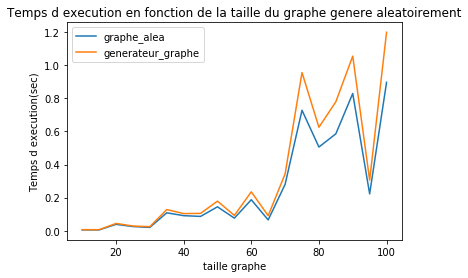

In [10]:
#Representation graphique
#Trace 
plt.plot(n,temps1,n,temps2)
plt.title("Temps d execution en fonction de la taille du graphe genere aleatoirement")
plt.legend(["graphe_alea","generateur_graphe"])
plt.xlabel("taille graphe")
plt.ylabel("Temps d execution(sec)")


On peut remarquer que la tendance générale des deux courbes sont similaires. Cependant, la fonction *graphe_alea* permet de générer des graphes en un temps plus court que *generateur_graph*. Néanmoins, *generateur-graph* permet de controler plus de paramètres du graphe généré(nombre d'arc précis, graphe acyclique, graphe simple) et ceci nous sera utile pour la suite de notre projet. Ainsi lors de nos différentes etudes, nous privilligirons *generateur_graph*. 

# Résolution d'un problème de Plus Court Chemin avec Contraintes(PCCC)
## Definition

* **Etiquette** : vecteur associé à un chemin et dont les coordonnées sont le coût et les consommations des différentes ressources.
* **Orde de Pareto** : Une étiquette **E** domine **E'** ssi toute les cordonnées de E sont supérieur ou égale à celle de E' et qu’au moins une coordonnée de E est strictement supérieur à celle de E'.


## Algorithme à correction d'étiquettes
On utilisera **l'algorithme à correction d'étiquettes**. 
On considère un graphe de source le sommet s et de puit le sommet t.
A chaque sommet i on associe un ensemble d'étiquettes **E<sub>s,i</sub>** qui correspondes à des chemins entre la source et ce sommet.
A l'initialisation, tous les ensembles **E<sub>s,i</sub>** sont vides car aucun chemin n'a été traité exépté **E<sub>s,s</sub>** qui vaut {0}.


On condisere une liste **L** qui contient l'ensemble des sommet dont au moins une étiquette n'a pas encore été propagé. On met a jour **L** a chaque itération.
  
A chaque intération, on choisi un sommet de **L** et on propage ses étiquette à ses successeurs si cette propagation respecte les contraintes. On élimine ce sommet de **L**. On ajoute ainsi de nouvelles étiquettes à ses successeur sur lesquelles on effectuera un test de domination au sens de l'ordre de Pareto afin de ne conserver que les étiquettes non-dominées.
Ce test assure que les **E<sub>s,i<sub>** sont Pareto-optimal et permet d'éventuellement **corriger** les étiquettes déjà existantes , d'où le nom de l'algorithme.

A chaque fois qu'on crée une nouvelle étiquette qui est maintenu après le test de domination, le sommet qui lui correspond est ajouté à la liste **L**. L'algorithme s'arrête une fois que la liste est vide donc lorsque tous les sommets sont traités et que les propagations ne change plus les étiquettes.

Sur tous les sommets et particulièrement en t, l'algorithme permet d'obtenir une ou plusieurs étiquettes non dominées  donc candidates comme solutions du problème.
Etant donné que le but est de minimiser le cout de s à t, l'algorithme renvoie le chemin ayant le cout le plus faible en t. S'il y en a plusieurs, on en choisit un. 
Notons que dans cet algorithme, on calcule le plus court chemin contraint de s à tous les autres sommets du graphe.

![Algorithme](https://drive.google.com/uc?id=1GNPnNF0-vO_jykku-rCmQeSDKuthGv9E)


In [11]:
""" Création d'une fonction Pareto qui prend comme paramètre un ensemble d'étiquette 
(et argument facultatif correspondant aux prédécésseur de ces etiquette) et renvoie
un ensemble Pareto minimale
"""
def ordre_Pareto(arc1,arc2):
    arc = arc1 - arc2
    retour = None
    if np.all(arc>=0)==True:
        retour =np.array([arc2])
    elif np.all(arc<=0)==True:
        retour = np.array([arc1.tolist()])
    else:
        retour = np.array([arc1,arc2])
    return(retour)

#Fonction qui permet de supprimer les doublons d'un ensemble d'étiquette avec leur prédécesseurs
def supp_doublon(E,P):
  #enleve les valeurs dupliques
  uniq_value=np.unique(E,axis=0,return_index=True,return_counts=True)
  if(P is not None):
    P=P[uniq_value[1]]
  E=uniq_value[0]
  return([E,P])

#Fonction renvoie l'ensemble Pareto optimal d'un ensemble d'étiquette avec leurs prédécesseur 
def Pareto(Etiq,Pred=None):
   #Enleve les étiquettes dupliqués
   [Etiq,Pred]=supp_doublon(Etiq,Pred)
   #Conserve uniquement les element non dominés
   i=0
   while(i < len(Etiq)): 
     element1=Etiq[i]
     j=0
     recommencer=False
     while(j < len(Etiq)):
       if(i!=j):
        element2=Etiq[j]
        test=ordre_Pareto(element1,element2)
        if(len(test)==1):
          supp=j if np.all(element1==test[0]) else i
          Etiq=np.delete(Etiq,supp,axis=0)
          if(Pred is not None):
            Pred=np.delete(Pred,supp)
          if supp==i:
            j,recommencer=len(Etiq),True
          if supp==j:
            j+=-1  
       j+=1
     if not recommencer:
      i+=1
   resu=[Pred,Etiq] if Pred is not None else Etiq
   return(resu) 

In [12]:
# Exemple d'utilisation
E=np.array([[30,15,11,20],
            [27,10,9,12],
            [30,15,11,20],
            [32,9,10,10],
            [35,14,11,18]])
P=np.array(["A","B","C","D","E"])

Pareto(E,P)


[array(['B', 'D'], dtype='<U1'),
 array([[27, 10,  9, 12],
        [32,  9, 10, 10]])]

In [13]:

""" Algorithme à correction d'étiquettes 
"""

#Fonction qui renvoie le plus court chemin dans l'algorithme à correstion d'etiquette
def PCC(E,source="s",puit="t"):
  chemin=[puit]
  if E[puit]==[]:
      print("Aucun chemin respectant les contraintes ")
      return(-1)
  else:
      #etiquette du puit correspondant au chemin qui minimise le cout
      cout_mini_chemin=E[puit][1][::,0]==min(E[puit][1][::,0])
      pred=E[puit][0][cout_mini_chemin][0]
      chemin.append(pred)
      #remonte les etiquettes du puit jusqu'a la source pour construire le chemin
      while pred!=source:
        cout_mini=E[pred][1][::,0]==min(E[pred][1][::,0])
        pred=E[pred][0][cout_mini][0]
        chemin.append(pred)
      return([chemin[::-1],E[puit][1][cout_mini_chemin]])

#Fonction correspondant a l'algorithme a correction d'etiquette
def correc_etiquette(g,contraintes,source="s",puit="t",acyclique=None,nv_ordre=None):
  if(source not in g.noeud or puit not in g.noeud):
    print("Erreur: votre source ou votre puit ne figurent pas parmi les sommets de votre graph")
    return(-1)
  #Initialisation
  List=[source]
  Etiq={noeud: [] for noeud in g.noeud}
  Etiq[source]=[np.array([source]),np.array([np.zeros(g.nb_ressources+1)])]
  itera=0
  temps_pareto=0
  if acyclique is None:
    acyclique=g.isAcyclic()
  #Reduire le nombre d'arc
  for i in g.arc.keys():
    for j in g.arc[i].keys():
      g.arc[i][j]=Pareto(g.arc[i][j])
  while(len(List)!=0):
    itera+=1
    if acyclique:
      ordre_topo_min=[g.sigma[k] for k in List]==np.min([g.sigma[k] for k in List])
      i=[List[l] for l in range(len(List)) if ordre_topo_min[l]][0]
    else:
      if nv_ordre is None:
        i=r.choice(List)
      elif nv_ordre==0:  
        i=List[0]
      else:
        i=List[len(List)-1]
    List.remove(i)
    if(i in g.arc.keys()):
      for j in g.successeurs(i):
        for k in range(len(Etiq[i][1])):
          E=Etiq[i][1][k]
          arc_ij=g.arc[i][j]
          for h in range(len(arc_ij)):
              if(np.all(arc_ij[h][1:len(arc_ij[h])]+E[1:len(E)]<=contraintes)):
                E2=arc_ij[h]+E
                if len(Etiq[j])==0:
                  Etiq[j]=[np.array([i]),np.array([E2])]
                  t1=time.time()
                  Etiq[j]=Pareto(Etiq[j][1],Etiq[j][0])
                  temps_pareto+=(time.time()-t1)
                  if(E2 in Etiq[j][1] and j not in List):
                    List.append(j)
                else:
                  if not any((Etiq[j][1][:]==E2).all(1)):
                    Etiq[j][1]=np.append(Etiq[j][1],np.array([E2]),axis=0)
                    Etiq[j][0]=np.append(Etiq[j][0],i)
                    Etiq[j]=Pareto(Etiq[j][1],Etiq[j][0])
                    if(any((Etiq[j][1][:]==E2).all(1)) and j not in List):
                      List.append(j)

       
  return([PCC(Etiq,source=source,puit=puit),[itera]])


### Convergence

On cherche ici à montrer que l'algorithme se termine en un nombre fini d'itérations.  

LIST = ensemble des sommets sur lesquels il existe des étiquettes non traitées (non propagées), lorsqu’il est vide l’algorithme s’arrête.  

Soit j un sommet du graphe différent de la source s.  
A chaque fois qu’un sommet j rentre dans LIST, on lui associe une nouvelle étiquette Pareto-optimale (non dominée) et le chemin correspondant entre la source s et j. Au niveau de j il peut y avoir plusieurs étiquettes non dominées correspondant à des chemins différents ou non.  
Supposons le graphe acyclique. Alors il existe un nombre fini de chemins entre s et j donc un nombre fini d’étiquettes non dominées correspondant à ces chemins. Si le graphe n’est pas acyclique, alors il peut exister un nombre infini de chemins entre s et j. On sait qu’il existe des contraintes finies de type borne sup pour chaque ressource et chaque ressource est définie comme positive. Pour ne pas dépasser la consommation de ressource maximale et par positivité des ressources chaque chemin entre s et j passe donc par le même sommet un nombre fini de fois. Ainsi, il existe un nombre fini de chemins entre s et j donc un nombre fini d’étiquettes non dominées associées à ces chemins. Dans les 2 cas, on en déduit que la mise à jour des étiquettes non dominées ne peut se faire qu’un nombre fini de fois donc un sommet entre dans la liste un nombre fini de fois. La liste LIST ne peut donc que se vider, ce qui veut dire que l’algorithme se termine en un temps fini.  

S’il n’existe pas de chemins entre s et t, l’algorithme ne renvoie rien.  
Sinon, considérons l’ensemble des étiquettes au sommet t. Chaque étiquette est associée à un chemin entre la source et le puit. La première coordonnée de chacune des étiquettes correspond au coût du chemin associé. Le nombre d’étiquettes étant fini il existe donc un coût minimal et l’algorithme renvoie ainsi le chemin ayant le plus petit coût au puit t.  


#### Exemple de résolution

Un jeune politicien, Paul Politics, a pour objectif de se présenter aux prochaines élections. Sauf surprise, il est assuré de gagner. Cependant, il sait également que la vie d'un politicien classique se termine lorsqu'il finit "déchu", n'ayant plus le soutien de la population. 
Entre le début de la campagne et sa certaine déchéance, son objectif est de minimiser l'argent investi tout en ayant des contraintes sur 3 ressources : le nombre de ses collaborateurs, son énergie dépensée (son niveau d'implication), la distance parcourue en déplacement.
Entre le debut de sa campagne et sa decheance, il peut passer par certaines étapes qui seront les sommets de notre graphe : la source sera donc le debut de la campagne et le puit la decheance.



In [14]:
Paul = Graphe()
Paul.ajout_ressource(["nb_colab","distance","energie"])
Paul.ajoutNoeud(["Debut","Meetings","Conferences","Financement","Corruption","Demagogie","Election","Decheance"])
Paul.ajoutArc(["Debut","Debut","Debut","Financement","Conferences","Conferences","Meetings","Corruption","Corruption","Demagogie","Election"],
              ["Meetings","Conferences","Financement","Conferences","Corruption","Demagogie","Corruption","Election","Decheance","Election","Decheance"],
              [[15,1,3,4],[10,1,4,5],[8,2,6,5],[4,5,6,2],[20,2,0,1],[2,3,9,1],[10,3,0,4],[1,6,2,8],[2,6,6,4],[4,3,2,2],[4,5,6,4]])

"""Vecteur consommation max de ressources 
1 - Pas plus de 12  collaborateurs
2-  Pas plus de 20 unités d'energie
3-  Une distance inférieure à 15 unités"""
conso = np.array([12,20,15])
parcours = correc_etiquette(Paul,conso,"Debut","Decheance")
print("Chemin :",parcours[0][0],"\n Consommation:",parcours[0][1])

Chemin : ['Debut', 'Meetings', 'Corruption', 'Decheance'] 
 Consommation: [[27. 10.  9. 12.]]


## Etude Empirique

Désormais, nous allons effectuer une étude empirique de notre algorithme afin de pouvoir visualiser son temps d'execution en fonction de divers paramètres.

Tout d'abord, commençons par visualiser le temps d'execution de notre algorithme en fonction du nombre de sommmets,d'arc et de ressources ainsi que des contraintes de manière séparé.Nous considerons des contraintes finales pour la suite de l'etude empirique.

Pour étudier l'impact du nombre de noeud, nous avons généré des graphes aleatoires avec un nombre de sommet compris entre 5 et 58.Tous les graphes ont 10000 arcs et une ressource dont la contraintes sur la borne supérieure est de 1000.

Pour étudier l'impact du nombre d'arc, nous avons généré des graphes aléatoires avec 100 noeuds et dont le nombre d'arc varie entre 110 et 3500. Chaque graphe a un ressource dont le contrainte sur la borne supérieur est de 900.

Pour étudier l'impact du nombre de ressource, nous avons généré des graphes aléatoires avec 10 noeuds et 100 arcs et dont le nombre de ressources varie entre 1 et 12. Les ressources ont une contrainte sur la borne supérieur est de 10000.

Pour étudier l'impact des contraintes, nous avons généré des graphes aléatoires avec 100 noeuds et 450 arcs avec une ressource. On fait varier la contraintes sur la borne sup de 10 à 200.

Pour chaque cas, nous avons effectué une moyenne du temps d'execution sur 5 graphe. Voici ci-dessous les resultats de cette etude.

Correlation entre le temps d'execution et le nombre de sommet: 0.939
Correlation entre le temps d'execution et le nombre d'arcs: 0.973
Correlation entre le temps d'execution et le nombre de ressources: 0.732
Correlation entre le temps d'execution et les contraintes: 0.953


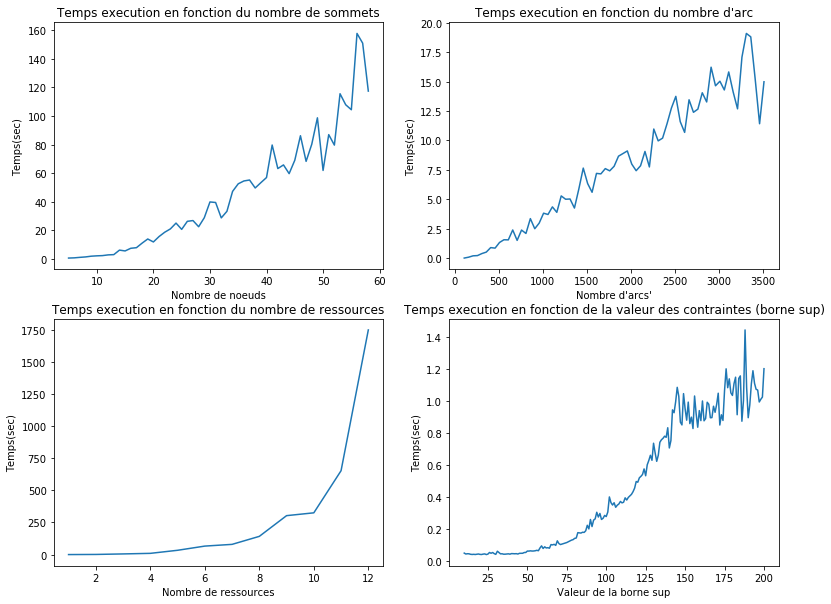

In [15]:
figure = plt.figure(figsize=(13,10))
#Sommet
plt.subplot(221)
plt.plot(noeud['n'],noeud['temps'])
plt.title("Temps execution en fonction du nombre de sommets")
plt.ylabel("Temps(sec)")
plt.xlabel("Nombre de noeuds")
corr=round(np.corrcoef(noeud['n'],noeud['temps'])[1,0],3)
print("Correlation entre le temps d'execution et le nombre de sommet:",corr)
#Arc
plt.subplot(222)
plt.plot(arc['m'],arc['temps_alea'])
plt.title("Temps execution en fonction du nombre d'arc")
plt.ylabel("Temps(sec)")
plt.xlabel("Nombre d'arcs'")
corr=round(np.corrcoef(arc['m'],arc['temps_alea'])[1,0],3)
print("Correlation entre le temps d'execution et le nombre d'arcs:",corr)
#Ressources
plt.subplot(223)
plt.plot(ressource['ressource'],ressource['temps'])
plt.title("Temps execution en fonction du nombre de ressources")
plt.ylabel("Temps(sec)")
plt.xlabel("Nombre de ressources")
corr=round(np.corrcoef(ressource['ressource'],ressource['temps'])[1,0],3)
print("Correlation entre le temps d'execution et le nombre de ressources:",corr)
#Ressources
plt.subplot(224)
plt.plot(contrainte['Contraintes'],contrainte['temps'])
plt.title("Temps execution en fonction de la valeur des contraintes (borne sup)")
plt.ylabel("Temps(sec)")
plt.xlabel("Valeur de la borne sup")
corr=round(np.corrcoef(contrainte['Contraintes'],contrainte['temps'])[1,0],3)
print("Correlation entre le temps d'execution et les contraintes:",corr)

## Commentaires

**Influence du nombre de sommets**  
Concernant le temps d'execution en fonction du nombre de sommets, on peut remarquer qu'il y a une forte correlation, ce qui est assez cohérent. En effet en augmentant le nombre de sommets on augmente potentiellement le nombre de sommet qu'on fait entré dans la liste et donc le nombre d'itérations dans l'algorithme . L'algorithme utilisé pour résoudre le problème de PCCC est un algorithme de programmation dynamique donc on s'attend à avoir une évolution polynomiale en fonction du nombre de sommets et c'est ici le cas.

**Influence du nombre d'arcs**  
La courbe obtenue montre une variance peu elevée mais présente dans les temps d'exécution (existence de faibles pics) mais permet également d'observer une tendance linéaire par rapport au nombre d'arcs. Ici encore, le coefficient de corrélation est très elevé proche de 1. 

**Influence des ressources**  
Pour ce graphe, nous avons choisi des paramètres assez réduit pour mieux illustrer l'influence du nombre de ressources. Pour un graphe de 10 sommets et de 100 arcs, on observe une croissance assez rapide du temps d'exécution avec le nombre de ressources. Un nombre de ressources élevé entraine une explosion du temps de convergence de l'algorithme car on a une explosion du nombre d'étiquettes non dominées par sommets.

**Influence des contraintes**   
Nous avons également observé l'effet de la valeur de la borne supérieure dans le temps d'exécution de l'algorithme. Plus la valeur de la borne inf est elevée, plus il y a de chemins admissibles donc l'algorithme met plus de temps. On remarque qu'à un moment donné, le temps stagne. Cela est du à nos paramètres (100 sommets, 450 arcs, 1 ressource) qui sont fixes.En effet,pour un graphe donné, à partir d'un certain seuil, la valeur de la contrainte sur la borne sup n'est plus contraignante et donc l'augmenter ne modfie plus le temps de resolution.


## **Ordonnancement du traitement des sommets**
Desormais, nous nous interessons à differéntes façon de diminuer le temps d'execution. Pour cela, nous commençons par nous concentrer sur l'ordonnencement des sommets (l'ordre dans lequel on traite les sommets). En effet, jusqu'à présent, nous séléctionnions un sommet au hasard dans la liste des sommets à traiter, puis propagions ses étiquettes sur ses successeurs. Désormais, nous allons voir si il existe un ordre de traitement qui permettrait de diminuer le temps d'execution.
##### Graphe acyclique
Le premier cas de figure que nous avons traité est celui des graphes acyclique. En effet, si un graphe est acyclique, nous pouvons attribuer à ses sommet un ordre topologique. Pour cela, nous avons codé une méthode dans la classe *Graphe* qui permet de determiner si un graphe est acyclique ou non et dans le cas positif, stock un ordre topoligique de ce dernier à l'aide d'un parcour en profondeur. Ainsi, dans l'algorithme à correction d'étiquette, nous selection le sommet dans la liste qui a le plus petit rang. En effet en procédent ainsi, on s'assure que chaque sommet entre une seule fois dans la liste des sommet à traiter.
Afin d'évaluer la plus-value que nous apporte cet ordonnancement, nous avons généré des graphes acyclique à l'aide de *generateur_graph* et avons comparé le temps d'execution. Nous pouvons voir ci-dessous le graphique permettant de visualiser nos résultats.


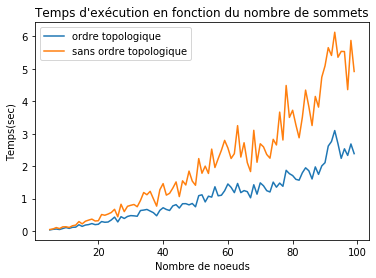

In [16]:
plt.plot(acyclique['n'],acyclique['topo'],
        acyclique['n'],acyclique['alea'])
plt.legend(["ordre topologique","sans ordre topologique"])
plt.title("Temps d'exécution en fonction du nombre de sommets")
plt.ylabel("Temps(sec)")
plt.xlabel("Nombre de noeuds")
plt.show()

Le gain de performance est ici évident, l'ordre de traitement des sommets dans *LIST* de l'algorithme joue un rôle important dans la vitesse de convergence de l'algorithme. Dans le cadre plus général, regardons l'effet de l'ordonnancement.

##### **Graphes quelconque**
Concernant les graphes quelconque, l'ordonnancement du traitement des sommets est plus délicat. En effet, il n'existe pas d'ordre qui permette de nous assurer qu'une fois qu'un sommet est traité, celui-ci ne sera plus ajouté dans la liste. Cependant, de la façon dont nous avons codé l'algorithme à correction d'étiquettes, les sommets à traiter stocke dans la liste *List* sont ordonnés par rapport à la plus petite longueur du chemin calculé entre la source et eux. Ainsi, nous avons voulu comparé le temps d'execution de l'algorithme lorsque nous prenions un sommet au hasard dans *List*, le premier élément (First-In-First-Out) et le dernier element (Last-In-First-Out). Voici ci dessous les resultats de la comparaison.

Text(0.5, 0, 'Nombre de noeuds')

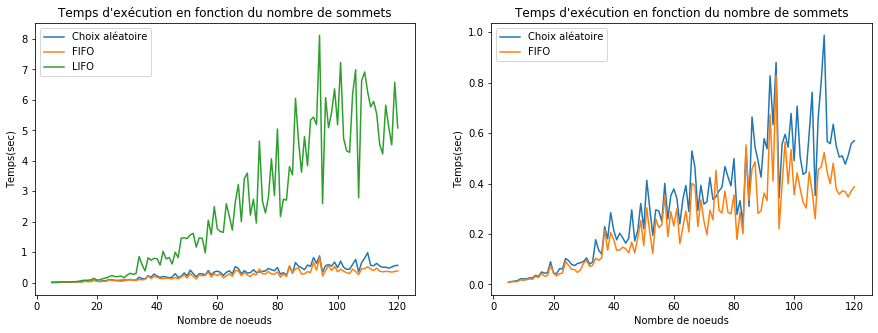

In [17]:
figure=plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(ordre['Nombre de sommets'],ordre['Temps avec choix aléatoire'],
        ordre['Nombre de sommets'],ordre['Temps avec premier élément'],
        ordre['Nombre de sommets'],ordre['Temps avec dernier éléement'])
plt.legend(["Choix aléatoire","FIFO","LIFO"])
plt.title("Temps d'exécution en fonction du nombre de sommets")
plt.ylabel("Temps(sec)")
plt.xlabel("Nombre de noeuds")
plt.subplot(122)
plt.plot(ordre['Nombre de sommets'],ordre['Temps avec choix aléatoire'],
        ordre['Nombre de sommets'],ordre['Temps avec premier élément'])
plt.legend(["Choix aléatoire","FIFO"])
plt.title("Temps d'exécution en fonction du nombre de sommets")
plt.ylabel("Temps(sec)")
plt.xlabel("Nombre de noeuds")

On observe nettement l'effet de l'ordre de choix des sommets dans le temps d'exécution de l'algorithme. L'ordre Last-In-First-Out amène une perte considérable de performance de l'algorithme. Sur le graphe de droite, on compare maintenant uniquement l'ordre First-In-First-Out et le choix aléatoire de sommet dans LIST. Le fait de choisir le premier élement de la liste (l'ordre First-In-First-Out) permet de gagner du temps. Ce gain de temps n'est pas important pour les graphes de petites taille mais on remarque qu'il augmente avec le nombre de sommets. Ainsi pour les n (nombre de sommets) proches de 120, la différence se fait de plus en plus ressentir.

## **Contraintes à fenetre de temps**
Jusqu'à présent, nous avons travaillons travaillé sur des contraintes dites finales et donc identique pour tous les sommets. Cependant, il est aussi intéréssant de pouvoir ajouter des contraintes différentes sur les autres sommets (contraintes à fenetres de temps).Par exemple, si nous reprenons l'exemple de Paul Politics, il serait peut intéressant d'imposer que l'energie dépensée lorsqu'on passe par le sommet *Financement* soit inférieur à un certain seuil. Afin d'inclure ces contraintes à fenêtre de temps, il nous a suffit de modifier quelques lignes de notre fonction. En effet, desormais, lorsque l'utilisateur utilise la fonction ***correc_etiquette***, il peut entrer les contraintes sous forme de liste ou sous forme de dictionnaire. Chaque clé du dictionnaire est un sommet du graphe et pointe vers une liste qui contient les contraintes, donc les fenêtres de temps sur chaque sommet. S'il utilise une liste, cela signifie qu'il considère des contraintes finales.
(voir ci-dessous la version finale de l'algo avec le prétraitement)


## **Pré-traitement**
Afin de diminuer le temps d'execution de notre algorithme, nous avons aussi mis en place une procédure de prétraitement permettant de réduire le nombre d'arcs et de sommets de notre graphe.Le principe de cette procédure est la suivante: On a une borne supérieur du cout  ***U*** et on supprime tout les sommets et arcs qui ont un cout supérieur ou bien ne respecte pas les contraintes. Voici ci-dessous une explication plus détaillé

*   Tout d'abord, nous calculons le plus court chemin par rapport au cout entre la source et chaque sommet puis entre chaque sommet et le puit. Ensuite, on fait la même chose mais par rapport à chaque ressource.
*   Ensuite on vérifie si il existe une solution. En effet si le plus court chemin entre la source et le puit par rapport à une ressource r ne respecte pas sa contrainte, il n'existe pas de solution. A l'opposé, si il existe un plus court chemin entre la source et le puit par rapport au cout et qui respecte toute les contrainte, c'est une solution optimale.

* On met à jour ***U***. Pour cela, on procède de deux manières. Premièrement, si il existe un pcc par rapport à une ressource entre la source et et le puis qui respecte les contraintes et dont le cout est inférieur à ***U***, on le met à jour. Ensuite, on considère un arc *(i,j)* ainsi que tous les pcc de s à i et tous les pcc de j à t défini à la première étapes. Si en combinant ces pcc et avec l'arc *(i,j)*, on trouve un chemin de s à t respectant les contraintes et dont le cout est inférieur à ***U***, on le met à jour. 

*   Enfin, vient l'étape de suppression de noeuds et d'arcs. Si le plus pcc par rapport à une ressource de s à t passant par un sommet ne respecte pas la contrante sur cette ressource, on supprime ce sommet ainsi que tous ses arcs incident. De plus si le pcc par rapport au cout de s à t passant par un sommet à un cout supérieur à ***U***, on supprime  ce sommet ainsi que tous ses arcs incident. On procède de la même manière pour les arcs. Si  on a supprimer au moin un sommet on retourne à la première étape.



Pour calculer les plus court chemins, on utilise l'algorithme de Djikstra, on suppose donc donc le cout est positif. Cependant, la procédure serait identique en utilisant l'algorithme de Bellman-Ford.
 

In [18]:
"PRETRAITEMENt"
#Djikstra
def Plus_Court_Chamin(g,i_couts,source='s',puit='t',tout_sommet=False):
  if source==puit:
    return([[source],np.array([0 for k in range(g.nb_ressources+1)])])

  Pred={k:None for k in g.noeud}
  Pred[source]=[source]
  L={k:[np.inf for h in range(g.nb_ressources+1)] for k in g.noeud}
  L[source],M,A=[0 for h in range(g.nb_ressources+1)],[],{i:{j:g.arc[i][j] for j in g.arc[i].keys()} for i in g.arc.keys()}
  #enleve les arcs inutiles pour les n-graphes
  n_graphe=max([max([len(g.arc[i][j]) for j in g.arc[i].keys()]) for i in g.arc.keys()])
  if n_graphe>1:
    for i in A.keys():
      for j in A[i].keys():
        cout_min=min([A[i][j][k][i_couts] for k in range(len(A[i][j]))])
        ind_min=[k for k in range(len(A[i][j])) if A[i][j][k][i_couts]==cout_min][0]
        A[i][j]=[A[i][j][ind_min]]

  while(len(M)!=len(g.noeud)):
    poids_min=min([L[j][i_couts] for j in g.noeud if j not in M])
    s=[k for k in g.noeud if k not in M and L[k][i_couts]==poids_min][0]
    M.append(s)
    for t in g.successeurs(s):
      if t not in M:
        cout_min=A[s][t][0][i_couts]
        if L[s][i_couts]+cout_min<L[t][i_couts]:
          L[t]=L[s]+A[s][t][0]
          Pred[t]=s

  if not tout_sommet:#renvoi uniquement le chemin de la source au puit
    if Pred[puit] is None:
      return([None,L[puit]])
    
    chemin=[puit,Pred[puit]]
    while chemin[len(chemin)-1]!=source:
      chemin.append(Pred[chemin[len(chemin)-1]])
    return([chemin[::-1],L[puit]])
  else:#renvoi tous les chemins de la source
    chemin={i:[] for i in g.noeud}
    for i in chemin.keys():
      if Pred[i] is None:
        chemin[i]=[None,L[i]]
      else:
        chemin[i]=[i]
        while chemin[i][len(chemin[i])-1]!=source:
          chemin[i].append(Pred[chemin[i][len(chemin[i])-1]])
        chemin[i]=[chemin[i][::-1],L[i]]
    return(chemin)

#================Pretraitement================#
def PRETRAITEMENT(G,b,s='s',t='t'):
  g=copy.deepcopy(G)
  V,A=[nd for nd in g.noeud],{i:{j:g.arc[i][j] for j in g.arc[i].keys()} for i in g.arc.keys()}
  L,U=0,np.max([np.max([g.arc[i][j][0] for j in  g.arc[i].keys()]) for i in g.arc.keys()]) * (len(g.arc)-1) + 1
  chg=True
  itera=0
  while chg:
    itera+=1
    chg=False
    if len(g.arc)==0:
      print("Aucun chemin")
      return(-1)
    #Calcul des plus courts chemins
    P_s=Plus_Court_Chamin(g,0,source=s,puit=t,tout_sommet=True)
    
    #Aucun chemin existant
    if P_s[t] is None:
      print("Aucun chemin")
      return(-1)
    elif np.all([P_s[t][1][k+1]<=b[k] for k in range(g.nb_ressources)]):
      print("Plus court Chemin respectant les contraintes")
      return([True,g,P_s[t]])
    else:
      L=P_s[t][1][0]
    
    P_t={i:Plus_Court_Chamin(g,0,source=i,puit=t) for i in g.noeud  }
    #Calcul des plus courts chemins pour les ressources
    P_s_r={k:Plus_Court_Chamin(g,k+1,source=s,puit=t,tout_sommet=True) for k in range(g.nb_ressources)}
    P_t_r={k:{i:Plus_Court_Chamin(g,k+1,source=i,puit=t) for i in g.noeud } for k in range(g.nb_ressources)}

    #Ressource
    if np.any([P_s_r[k][t][1][k+1]>b[k] for k in range(g.nb_ressources)]):
      print("Aucun chemin respectant les contraintes")
      return(-1)
    meilleur_ch=[np.all([P_s_r[k][t][1][q+1]<=b[q] for q in range(g.nb_ressources)]) and P_s_r[k][t][1][0]<=U  for k in range(g.nb_ressources)]
    if np.any(meilleur_ch):
      U=np.min([P_s_r[k][t][1][0] for k in range(g.nb_ressources) if meilleur_ch[k]])

    #Recombinaison des chemins
    for i in g.arc.keys():
      debut=[P_s[i][1]]+[P_s_r[k][i][1] for k in range(g.nb_ressources)]
      for j in g.arc[i].keys():
        fin=[P_t[j][1]]+[P_t_r[k][j][1] for k in range(g.nb_ressources)]
        consommation=g.arc[i][j]
        for conso in consommation:
          meilleur_combi=[np.all([deb[k+1]+conso[k+1]+fin2[k+1]<=b[k] for k in range(g.nb_ressources)]) and deb[0]+conso[0]+fin2[0]<=U for deb in debut for fin2 in fin]
          if np.any(meilleur_combi):
            cout=[deb[0]+conso[0]+fin2[0] for deb in debut for fin2 in fin]
            U=np.min([cout[k] for k in range(len(cout)) if meilleur_combi[k]])

    #Elimination de sommet
    for i in g.noeud:
      if i not in [s,t]:
        if np.any([P_s_r[k][i][1][k+1]+P_t_r[k][i][1][k+1]>b[k] for k in range(g.nb_ressources)]) or P_s[i][1][0]+P_t[i][1][0]>U :
          chg=True
          g.noeud.remove(i)
          g.arc.pop(i,None)
          for j in g.arc.copy().keys():
            g.arc[j].pop(i,None)
            if len(g.arc[j])==0:
              g.arc.pop(j,None)
    #Elimination d'arc
    for i in g.arc.copy().keys():
      for j in g.arc[i].copy().keys():
       consommation=g.arc[i][j]
       for conso in consommation:
         ress=np.any([P_s_r[k][i][1][k+1]+conso[k+1]+P_t_r[k][j][1][k+1]>b[k] for k in range(g.nb_ressources)])
         cout=P_s[i][1][0]+conso[0]+P_t[j][1][0]>U
         if ress or cout:
           chg=True
           g.arc[i].pop(j,None)
      if len(g.arc[i])==0:
        g.arc.pop(i,None)
    
  return([False,g,U,L])

Nous avons donc modifié ***correc_etiquette*** afin d'y inclure la procédure de pretraitement (et les fenêtres de temps).

In [19]:
#Fonction correspondant a l'algorithme a correction d'etiquette
def correc_etiquette(g,contraintes,source="s",puit="t",acyclique=None,nv_ordre=None,pretraitement=True):
  if(source not in g.noeud or puit not in g.noeud):
    print("Erreur: votre source ou votre puit ne figurent pas parmi les sommets de votre graph")
    return(-1)
  #Initialisation
  List=[source]
  Etiq={noeud: [] for noeud in g.noeud}
  Etiq[source]=[np.array([source]),np.array([np.zeros(g.nb_ressources+1)])]
  if type(contraintes) is not dict:
    contraintes={noeud: contraintes for noeud in g.noeud}
  itera=0

  if acyclique is None:
    acyclique=g.isAcyclic()
  #Reduire le nombre d'arc
  for i in g.arc.keys():
    for j in g.arc[i].keys():
      g.arc[i][j]=Pareto(g.arc[i][j])
  
  #pretraitement
  if pretraitement:
    pret=PRETRAITEMENT(g,contraintes[puit],s=source,t=puit)
    if pret==-1:#aucun chemin realisable
      return(-1)
    if pret[0]:#au moins un chemin realisable
      realisable=True
      i,conso=1,np.array(np.zeros(g.nb_ressources+1))
      #on verifie qu'il respecte les contraintes pour chaque fenetre de tempe
      while realisable and i<len(pret[2][0]):
        conso=conso+g.arc[pret[2][0][i-1]][pret[2][0][i]][0]
        if(np.any(conso[1:len(conso)]>contraintes[pret[2][0][i]])):
          realisable=False
        i+=1
      if realisable:
        return(pret[2])
    #on prend le graphe avec les arcs et sommets inutiles en moins
    g=pret[1]

  while(len(List)!=0):
    itera+=1
    if acyclique:
      ordre_topo_min=[g.sigma[k] for k in List]==np.min([g.sigma[k] for k in List])
      i=[List[l] for l in range(len(List)) if ordre_topo_min[l]][0]
    else:
      if nv_ordre is None:
        i=r.choice(List)
      elif nv_ordre==0:  
        i=List[0]
      else:
        i=List[len(List)-1]
    List.remove(i)
    if(i in g.arc.keys()):
      for j in g.successeurs(i):
        for k in range(len(Etiq[i][1])):
          E=Etiq[i][1][k]
          arc_ij=g.arc[i][j]
          for h in range(len(arc_ij)):
              if(np.all(arc_ij[h][1:len(arc_ij[h])]+E[1:len(E)]<=contraintes[j])):
                E2=arc_ij[h]+E
                if len(Etiq[j])==0:
                  Etiq[j]=[np.array([i]),np.array([E2])]
                  Etiq[j]=Pareto(Etiq[j][1],Etiq[j][0])
                  if(E2 in Etiq[j][1] and j not in List):
                    List.append(j)
                else:
                  if not any((Etiq[j][1][:]==E2).all(1)):
                    Etiq[j][1]=np.append(Etiq[j][1],np.array([E2]),axis=0)
                    Etiq[j][0]=np.append(Etiq[j][0],i)
                    Etiq[j]=Pareto(Etiq[j][1],Etiq[j][0])
                    if(any((Etiq[j][1][:]==E2).all(1)) and j not in List):
                      List.append(j)

  return([PCC(Etiq,source=source,puit=puit),[itera]])


In [20]:
#Exemple d'utilisation 
g=generateur_graph(26,50,nb_ress=2,b=10,graph_simple=True)
#contraintes a fentere de temps
contrainte={noeud:[r.choice([200+i for i in range(-10,10)]) for k in range(2)] for noeud in g.noeud}
s1=correc_etiquette(g,contrainte,pretraitement=True)
print("Resultat avec pretraitement \n",s1)
print("-----------------------")
#On retrouve biensur le même resultat sans le pretraitement
s2=correc_etiquette(g,contrainte,pretraitement=False)
print("Resultat sans pretraitement \n",s2[0:1])

Plus court Chemin respectant les contraintes
Resultat avec pretraitement 
 [['s', '1', '2', '3', '26', '21', '22', 't'], array([13, 33, 37])]
-----------------------
Resultat sans pretraitement 
 [[['s', '1', '2', '3', '26', '21', '22', 't'], array([[13., 33., 37.]])]]


#### **Impact du pretraitement**
Afin de visualiser l'impact du prétraitement sur le temps d'execution, nous avons réalisé une étude empirique en comparant le temps d'execution avec et sans prétraitement. Pour cela nous avons généré des graphes aléatoires avec un nombre de sommets compris entre 10 et 100, avec 2 ressources et nous avons fait une moyenne sur 5 instances différentes pour chaque nombre de sommets. Nous pouvons voir ci-dessous les résultats.

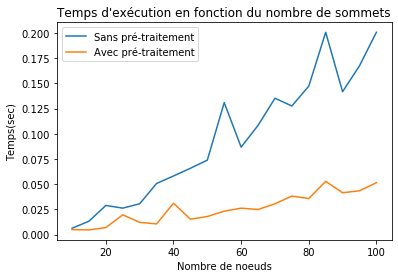

In [21]:
#Graphes
plt.plot(pretrmt['n'],pretrmt['temps_avant'],
        pretrmt['n'],pretrmt['temps_apres'])
plt.legend(["Sans pré-traitement","Avec pré-traitement"])
plt.title("Temps d'exécution en fonction du nombre de sommets")
plt.ylabel("Temps(sec)")
plt.xlabel("Nombre de noeuds")
plt.show()

**COMMENTAIRE**

On peut voir à l'aide du graphique que, bien que les deux courbes ont une tendance croissante, le prétraitement a permis de réduire significativement le temps d'execution.

## **Résolution par PuLP du modèle de PLNE**


Ici, on s'intéressera à la modélisation en PLNE du problème de PCCC . Le problème a été formalisé en première partie du notebook. On cherche le plus court chemin de s à t en respectant les contraintes de ressources.


### Variables
Pour tout $a \in A$ : $x_{a} \in ${$0,1$}$ = 1$ si et seulement si $a$ est dans le chemin choisi  

### Objectif
Minimiser le coût du chemin:  
${min} \sum \limits_{{a \in A}} c_a*x_a$

### Contraintes
Conservation du flot:  $\forall i \ne s,t$ on a  $\sum \limits_{(i,j)\in \delta^+(i)} x_{ij} = \sum \limits_{(j,i)\in \delta^-(i)} x_{ji}$

Flot entrant de t:  $\sum \limits_{(i,t) \in \delta^-(t)} x_{it} = 1$  
Flot sortant de s:  $\sum \limits_{(s,i) \in \delta^+(s)} x_{si} = 1$  
Contraintes de ressources sur les chemins:
$ \forall r\in ${$1,2,\dots, n_r $}, $\sum \limits_{a \in A} t^r_a*x_a \le b^r$ où $b^r$ est la consommation maximale de la ressource $r$.






In [22]:
def Consommation(graphe):
  n_graphe=[[len(graphe.arc[key1][key2]) for key2 in graphe.arc[key1].keys()]for key1 in graphe.arc.keys()]
  n_graphe=np.max(np.max(n_graphe))
  Conso={e:{} for e in ["couts"]+["r"+str(i+1) for i in range(graphe.nb_ressources)]}
  #Recupération des coûts associés à chaque arc, cout nul si arc non existant:
  for key1 in graphe.noeud:
    Conso['couts'][key1]={}
    for key2 in graphe.noeud:
      Conso['couts'][key1][key2]={}
      for n in range(n_graphe):
        if key1 in graphe.arc.keys():
          if key2 in graphe.arc[key1].keys():
            if n < len(graphe.arc[key1][key2]):
              Conso['couts'][key1][key2][n]=graphe.arc[key1][key2][n][0]
            else:
              Conso['couts'][key1][key2][n]=0
          else:
            Conso['couts'][key1][key2][n]=0
        else:
          Conso['couts'][key1][key2][n]=0
  #Pareil pour les ressources
  for e in range(graphe.nb_ressources):
    for key1 in graphe.noeud:
      Conso["r"+str(e+1)][key1]={}
      for key2 in graphe.noeud:
        Conso["r"+str(e+1)][key1][key2]={}
        for n in range(n_graphe):
          if key1 in graphe.arc.keys():
            if key2 in graphe.arc[key1].keys():
              if n < len(graphe.arc[key1][key2]):
                Conso["r"+str(e+1)][key1][key2][n]=graphe.arc[key1][key2][n][e+1]
              else:
                Conso["r"+str(e+1)][key1][key2][n]=0
            else:
              Conso["r"+str(e+1)][key1][key2][n]=0
          else:
            Conso["r"+str(e+1)][key1][key2][n]=0
  return([Conso,n_graphe])
  
def PCC_PLNE(graphe,b,source="s",puit="t"):
  Conso=Consommation(graphe)
  n_graphe=Conso[1]
  Conso=Conso[0]
  #Modelisation du probleme
  prob = LpProblem("PLNE", LpMinimize)
  ############################Variables#################################
  lignes = [e for e in graphe.noeud]
  x=LpVariable.dicts("x",(lignes,lignes,[i for i in range(n_graphe)]), 0,1,LpInteger)
  
  ############################Objectif##################################
  prob+=lpSum([lpSum([lpSum([x[i][j][k]*Conso['couts'][i][j][k] for k in range(n_graphe)]) for i in graphe.noeud]) for j in graphe.noeud])

  ###########################Contraintes################################ 
  #Conservation du flot
  for i in [e for e in graphe.noeud if e!=source and e!=puit ]:
    prob+=lpSum([lpSum([x[i][j][k] for k in range(n_graphe)]) for j in graphe.successeurs(i)])==lpSum([lpSum([x[j][i][k] for k in range(n_graphe)])  for j in graphe.predecesseurs(i)])

  #Flot sortant de la source et flot sortant du puit égal à 1
  prob+=lpSum([lpSum([x[source][j][k] for k in range(n_graphe)])  for j in graphe.successeurs(source)])==1
  prob+=lpSum([lpSum([x[j][puit][k] for k in range(n_graphe)])  for j in graphe.predecesseurs(puit)])==1

  #Si un arc 'a' n'existe pas, x[a] = 0
  for i in graphe.noeud:
    if i not in graphe.arc.keys():
      for j in graphe.noeud:
        for k in range(n_graphe):
          prob+=x[i][j][k]==0
    else:
      for j in graphe.noeud:
        for k in range(n_graphe):
          if j not in graphe.arc[i].keys():
            prob+=x[i][j][k]==0
          else:
            if k >= len(graphe.arc[i][j]):
              prob+=x[i][j][k]==0

  #Contraintes de ressources finales
  for e in range(graphe.nb_ressources):
    #Ressource
    prob+=lpSum([lpSum([lpSum([x[key1][key2][k]*Conso["r"+str(e+1)][key1][key2][k] for k in range(n_graphe)]) for key1 in graphe.noeud]) for key2 in  graphe.noeud]) <=b[e]


  ######################### Resolution ###########################################
  prob.writeLP("furniture.lp")
  prob.solve()
  print("Status:", LpStatus[prob.status])
  return(prob)

def Afficher_Plne(prob,model=True,chemin=True,Cout=True):
  #Affichage du modèle
  if model:
    print(prob)

  # On affiche le chemin
  if chemin:
    print("Affichage des résultats")
    for v in prob.variables():
        if(v.varValue!=0):
          print(v.name, "=", v.varValue)
  if Cout:    
    print("Cout minimal = ", value(prob.objective))

In [23]:
"""
On effectue un test avec 2 ressources et un graphe quelconque"""
graphe = Graphe()
graphe.ajout_ressource(["r1","r2"])
graphe.ajoutNoeud([0,1,2,3,4,5])
graphe.ajoutArc([0,0,1,1,2,2,3,3,4,4],
                [1,2,4,3,1,3,4,5,2,5],
                [[7,6,5],[4,3,2],[6,11,5],[8,10,4],[7,3,3],[9,4,2],[6,7,2],[7,5,4],[3,2,1],[3,4,3]])

"""Ici, la source sera le sommet 0 et 5 le sommet puit"""
b = [24,12]
opt=PCC_PLNE(graphe,b,"0","5")
Afficher_Plne(opt,model=False)
#On retrouve le meme resultat avec l'algorithme a correction d etiquettes
resu = correc_etiquette(graphe,b,"0","5")
print("\n Chemin :",resu[0],"\n Consommation:",resu[1])

Status: Optimal
Affichage des résultats
x_0_2_0 = 1.0
x_2_3_0 = 1.0
x_3_5_0 = 1.0
Cout minimal =  20.0
Plus court Chemin respectant les contraintes

 Chemin : ['0', '2', '3', '5'] 
 Consommation: [20 12  8]


### **Comparaison PLNE et Correction d'etiquette**

On cherche maintenant à déterminer quelle méthode est la plus intéressante en termes de temps d'éxecution. Pour un nombre de sommets allant de 1 à 100 et pour des ratios arcs/sommet différents, on évalue le temps d'exécution des deux méthodes. Tout d'abord, on commence par comparer plne et correction d'étiquette sans pré-traitement : 

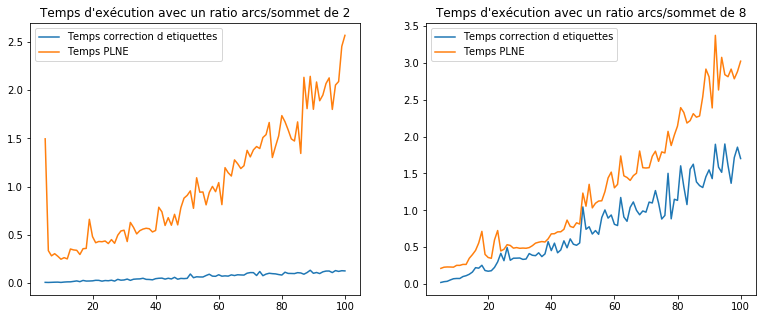

Text(0.5, 1.0, "Temps d'exécution avec arcs/sommet de 40")

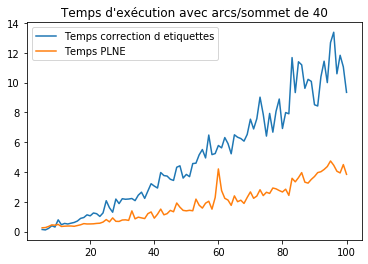

In [24]:
figure = plt.figure(figsize=(13,5))
#2*(nb_sommet)
plt.subplot(121)
plt.plot(comparaison[comparaison['m']==2]['n'],comparaison[comparaison['m']==2]['temps_pcc1'],
        comparaison[comparaison['m']==2]['n'],comparaison[comparaison['m']==2]['temps_plne'])
plt.title("Temps d'exécution avec un ratio arcs/sommet de 2")
plt.legend(["Temps correction d etiquettes","Temps PLNE"])


#8*(nb_sommet)
plt.subplot(122)
plt.plot(comparaison[comparaison['m']==8]['n'],comparaison[comparaison['m']==8]['temps_pcc1'],
        comparaison[comparaison['m']==8]['n'],comparaison[comparaison['m']==8]['temps_plne'])
plt.legend(["Temps correction d etiquettes","Temps PLNE"])
plt.title("Temps d'exécution avec un ratio arcs/sommet de 8")
plt.show()

#40*(nb_sommet)
plt.plot(comparaison[comparaison['m']==40]['n'],comparaison[comparaison['m']==40]['temps_pcc1'],
        comparaison[comparaison['m']==40]['n'],comparaison[comparaison['m']==40]['temps_plne'])
plt.legend(["Temps correction d etiquettes","Temps PLNE"])
plt.title("Temps d'exécution avec arcs/sommet de 40")


Ces graphes nous montrent que la performance des deux méthodes est également dépendante des paramètres. Il existe des configurations ou la PLNE permet de résoudre plus rapidement un problème de PCCC. Comme le dernier graphe le suggère, dans les cas où le ratio arcs/sommet est elevé, la PLNE nous donne de meilleures performances avec un temps deux fois moins long. Néanmoins lorsque le ratio arc/sommet est faible l'algorithme à correction d'étiquettes donne de bien meilleures performances comme le montre les deux premiers graphes.

Effectuons les mêmes comparaisons, cette fois en ayant effectué une procédure de pré-traitement avant d'utiliser l'algorithme à correction d'étiquettes.

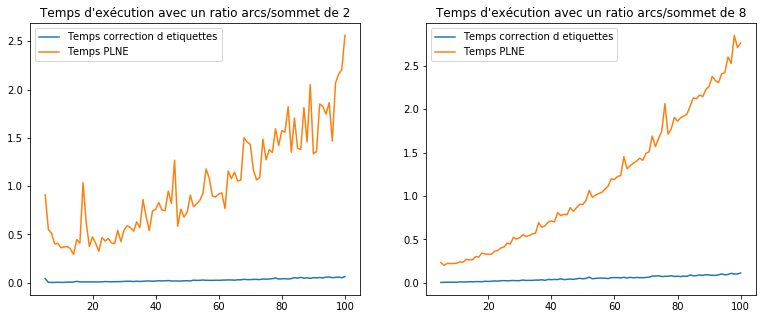

Text(0.5, 1.0, "Temps d'exécution avec arcs/sommet de 40")

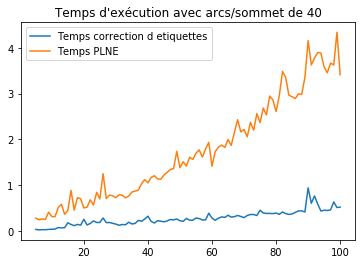

In [25]:
figure = plt.figure(figsize=(13,5))
#2*(nb_sommet)
plt.subplot(121)
plt.plot(comparaison2[comparaison2['m']==2]['n'],comparaison2[comparaison2['m']==2]['pccc'],
        comparaison2[comparaison2['m']==2]['n'],comparaison2[comparaison2['m']==2]['plne'])
plt.title("Temps d'exécution avec un ratio arcs/sommet de 2")
plt.legend(["Temps correction d etiquettes","Temps PLNE"])


#8*(nb_sommet)
plt.subplot(122)
plt.plot(comparaison2[comparaison2['m']==8]['n'],comparaison2[comparaison2['m']==8]['pccc'],
        comparaison2[comparaison2['m']==8]['n'],comparaison2[comparaison2['m']==8]['plne'])
plt.legend(["Temps correction d etiquettes","Temps PLNE"])
plt.title("Temps d'exécution avec un ratio arcs/sommet de 8")
plt.show()

#40*(nb_sommet)
plt.plot(comparaison2[comparaison2['m']==40]['n'],comparaison2[comparaison2['m']==40]['pccc'],
        comparaison2[comparaison2['m']==40]['n'],comparaison2[comparaison2['m']==40]['plne'])
plt.legend(["Temps correction d etiquettes","Temps PLNE"])
plt.title("Temps d'exécution avec arcs/sommet de 40")


On observe qu'avec un pré-traitement, l'algorithme à correction d'étiquette est plus efficace en terme de temps de calcul pour les trois ratios arcs/sommets.

# Bilan
Pour conclure, nous avons mis en place en place un algorithme permettant de calculer le PCCC d'un graphe en nous inspirant de l'algorithme à correction d'étiquette.Nous avons aussi apporté des modications à ce dernier afin d'améliorer son temps d'execution.Nous avons pu observer que notre fonction était sensible au nombre d'arc, de noeuds, de ressources et des contraintes de notre PCCC. Par ailleurs, nous avons aussi modélisé le PCCC à l'aide de la PLNE. 
Il serait intéréssant d'étudier l'autre famille d'algorithme pour résoudre ces problemes: les algorithmes à fixation d'étiquettes et de pouvoir faire des comparaisons. Par ailleurs, au vu du temps d'execution, la résolution exacte du PCCC peut prendre beaucoup de temps pour de grosses instances, il serait donc intéréssant de pouvoir étudier des méthodes heuristiques pour le resoudre.

### Aplication
Durant ce projet, nous avons mis en place une application web reprenant nos résultats. Nous avons développé cette application à l'aide du package shiny. Elle est hébérgé sur un server shiny et utilise nos codes pythons à l'aide d'un environnement virtuelle. 

Pour pouvoir accéder à notre application,[CLIQUEZ SUR CE LIEN](https://experience.shinyapps.io/aboahugo/) ( ce n'est pas une pub pour pirater votre ordinateur). Un guide d'utilisation y est présent pour vous expliquer son utilisation (Si vous ne voulez pas utiliser le guide, cliquez sur *plan par défaut* puis *montrez-moi le chemin*.